In [1]:
import numpy as np
from matplotlib import pyplot as plt
import theano as th
from theano import tensor as tt
from theano.tensor.shared_randomstreams import RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import raw_random

In [2]:
rng = RandomStreams()

In [3]:
th.config.floatX = 'float64'
th.config.exception_verbosity = 'high'

In [4]:
def transition_det(x):
    return 5*tt.sin(0.1*x)

def transition(x):
    return transition_det(x) + rng.normal(std=0.1, size=x.shape)

def emission_det(x):
    return tt.exp(5*x+0.1) + x

def emission(x):
    return emission_det(x) + rng.normal(std=1, size=x.shape)

In [5]:
inp = tt.vector(name='default input vector')

In [6]:
get_transition = th.function([inp], transition(inp))
get_emission = th.function([inp], emission(inp))

In [7]:
latent = [0.01]
for _ in range(1000):
    latent.append(get_transition(np.array([latent[-1]]))[0])

observe = get_emission(np.array(latent))

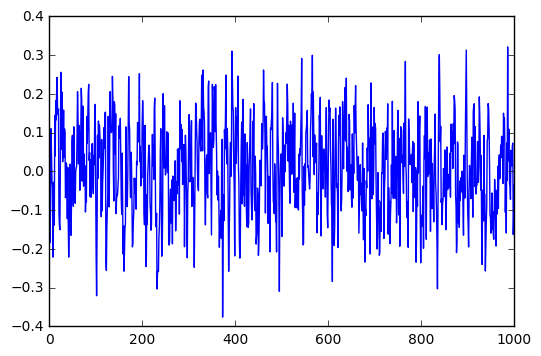

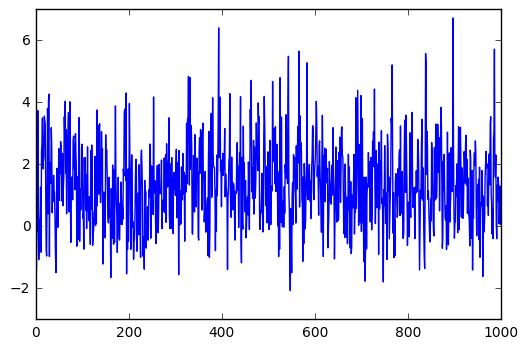

In [8]:
plt.plot(latent)
plt.show()
plt.plot(observe)
plt.show()

In [44]:
def prob(x, observation):
    pre = tt.exp(-(emission_det(x) - observation)**2/(2*1**2))
    return pre/pre.sum()

def resample(x, probs):
    return rng.choice(a=tt.arange(x.shape[0]), p=probs, replace=True, size=(40,), dtype='int64').T

def update(x):
    res, updates = th.scan(transition, non_sequences=x, n_steps=20)
    return res.reshape((-1,))[:800]

In [45]:
observe_th = th.shared(np.array(observe),name='observe')
init_sample = th.shared(np.random.normal(scale=3,size=(800,)), name='current sample')

In [52]:
def filt_iter (observation, x, y):
    probs = prob(y,observation)
    res = resample(y,probs)
    probs = probs[res]
    return y[res], update(x), probs/probs.sum()

results, updates = th.scan(filt_iter,
                           outputs_info = [{'initial':init_sample[:40]},{'initial':init_sample}, None],
                           sequences=observe_th)
results = [results[0], results[2]]

In [53]:
filtered = th.function([], results, updates=updates)

In [54]:
filt_distrib = filtered()

In [56]:
filt_distrib[1]

array([[ 0.00482048,  0.03691435,  0.04269908, ...,  0.01391335,
         0.04011319,  0.00010078],
       [ 0.03485201,  0.01168534,  0.01879951, ...,  0.03582435,
         0.02138285,  0.0167232 ],
       [ 0.02687375,  0.02939404,  0.01892633, ...,  0.03116495,
         0.01666707,  0.02662824],
       ..., 
       [ 0.02971224,  0.02251596,  0.02841482, ...,  0.02696968,
         0.02763656,  0.02866116],
       [ 0.03255606,  0.0253752 ,  0.02438581, ...,  0.02441013,
         0.02827711,  0.03296706],
       [ 0.02781947,  0.02791137,  0.02888427, ...,  0.02506454,
         0.02107408,  0.02861473]])

In [14]:
filt_distrib = np.array(filt_distrib)
filt_distrib = np.sort(filt_distrib, axis=1)

In [15]:
def step_back(x, probs):
    results, updates = th.map(lambda p: rng.choice(a=x.reshape((-1,)), replace=True,
                                                   p=p.reshape((-1,)), size=(1,), dtype='float64'), 
                              probs, name='traj mapper')
    return results.reshape((-1,)), updates

def back_sample(x, next_x):
    probs, updates = th.map(lambda piece: tt.exp(-((x - piece)**2)/(2*0.2**2)), next_x)
    probs /= tt.sum(probs, axis=1).reshape((-1,1))
    return step_back(x, probs)

In [ ]:
def get_denum(x):
    

In [16]:
filt_distrib_th = th.shared(filt_distrib, name='filtered distribution')

In [17]:
filt_distrib.shape

(1001, 400)

In [18]:
def iterfun(x, next_x):
    bs = back_sample(x, next_x)
    return (bs[0], bs[1])

results, updates = th.scan(iterfun, 
                           sequences=filt_distrib_th[::-1], 
                           outputs_info=filt_distrib_th[-1])
results = results[::-1]

In [19]:
smooth = th.function([],results, updates=updates)

In [20]:
trajectories = smooth()

In [21]:
trajectories.shape

(1001, 400)

In [22]:
trajectories = np.array(trajectories)
trajectories = np.sort(trajectories, axis=1)

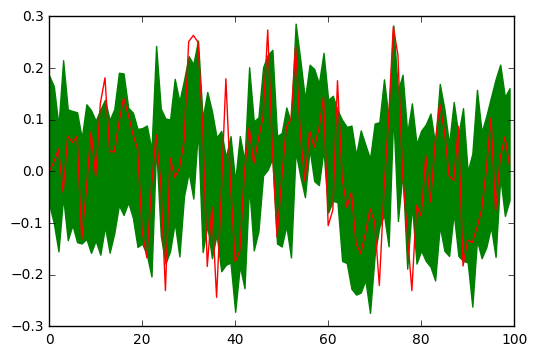

In [15]:
plt.fill_between(range(100),filt_distrib[-100:,3],filt_distrib[-100:,-3],color='green')
plt.plot(latent[-100:],color='red')
plt.show()

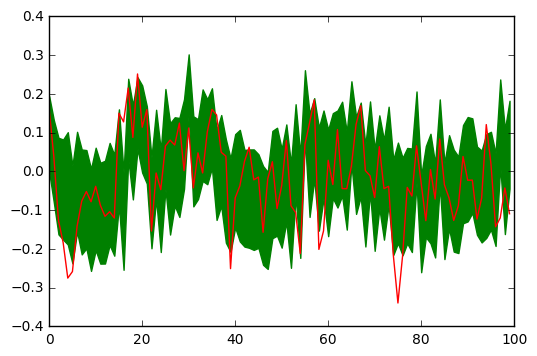

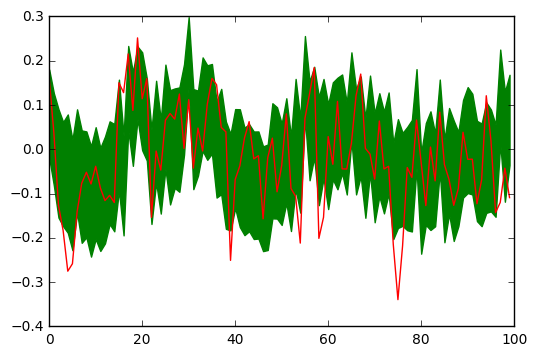

In [23]:
#plt.plot(filtered[-100:])
plt.fill_between(range(100),filt_distrib[-100:,30],filt_distrib[-100:,-30],color='green')
plt.plot(latent[-100:],color='red')
plt.show()
plt.fill_between(range(100),trajectories[-100:, 30],trajectories[-100:, -30],color='green')
plt.plot(latent[-100:], color='red')
plt.show()